In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
csv = Path("../data/raw/viirs_snpp_usa_last1d.csv")
df = pd.read_csv(csv)
df.head()

df.info()
df['acq_date'] = pd.to_datetime(df['acq_date'])
df[['latitude','longitude','bright_ti4','confidence']].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1998 entries, 0 to 1997
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country_id  1998 non-null   object 
 1   latitude    1998 non-null   float64
 2   longitude   1998 non-null   float64
 3   bright_ti4  1998 non-null   float64
 4   scan        1998 non-null   float64
 5   track       1998 non-null   float64
 6   acq_date    1998 non-null   object 
 7   acq_time    1998 non-null   int64  
 8   satellite   1998 non-null   object 
 9   instrument  1998 non-null   object 
 10  confidence  1998 non-null   object 
 11  version     1998 non-null   object 
 12  bright_ti5  1998 non-null   float64
 13  frp         1998 non-null   float64
 14  daynight    1998 non-null   object 
dtypes: float64(7), int64(1), object(7)
memory usage: 234.3+ KB


,latitude,longitude,bright_ti4
count,1998.000000,1998.000000,1998.000000
mean,51.408971,-125.670743,316.578418
std,14.418571,25.145821,16.042568
min,19.399890,-159.752810,295.010000
25%,37.420380,-144.509730,304.332500
50%,63.251110,-141.828240,311.540000
75%,63.874725,-102.216790,326.942500
max,69.473320,-74.542970,367.000000


In [3]:
df.columns

Index(['country_id', 'latitude', 'longitude', 'bright_ti4', 'scan', 'track',
       'acq_date', 'acq_time', 'satellite', 'instrument', 'confidence',
       'version', 'bright_ti5', 'frp', 'daynight'],
      dtype='object')

In [4]:
df.shape #1998 rows, 15 columns

(1998, 15)

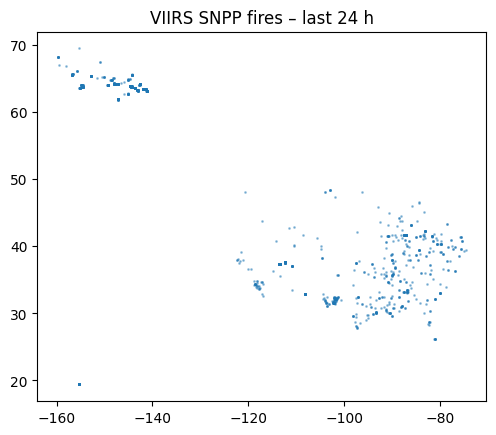

In [5]:
import geopandas as gpd, matplotlib.pyplot as plt
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"
)
ax = gdf.plot(markersize=1, alpha=0.4)
ax.set_title("VIIRS SNPP fires – last 24 h")
plt.show()


In [6]:
df.isna()

,country_id,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1994,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1995,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1996,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [7]:
df.isnull().any()

country_id    False
latitude      False
longitude     False
bright_ti4    False
scan          False
track         False
acq_date      False
acq_time      False
satellite     False
instrument    False
confidence    False
version       False
bright_ti5    False
frp           False
daynight      False
dtype: bool

In [8]:
df['confidence'].value_counts()
#his will tell whether most detections
#are reliable, and might even convert this to numeric
#labels later (LOW = 0, NOMINAL = 1, HIGH = 2 or 1/0 binary) using one-hotencoding

confidence
n    1940
l      31
h      27
Name: count, dtype: int64

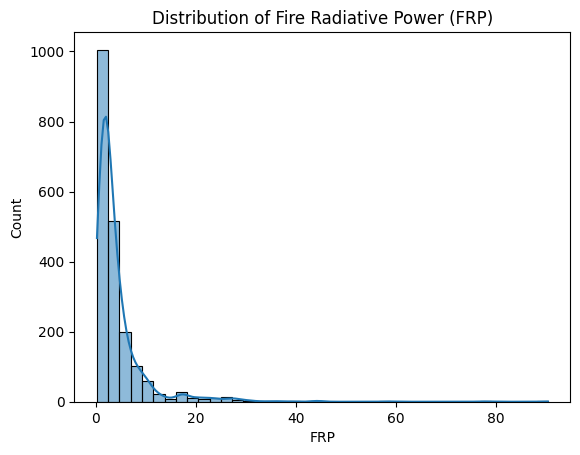

In [9]:
#the spread of fire intensity
import seaborn as sns
sns.histplot(df['frp'], bins=40, kde=True)
plt.title("Distribution of Fire Radiative Power (FRP)")
plt.xlabel("FRP") #Fire Intensity Distribution
plt.ylabel("Count")
plt.show()


In [10]:
df['daynight'].value_counts()

daynight
N    1758
D     240
Name: count, dtype: int64

<Axes: title={'center': 'Fires by Day/Night'}, xlabel='daynight'>

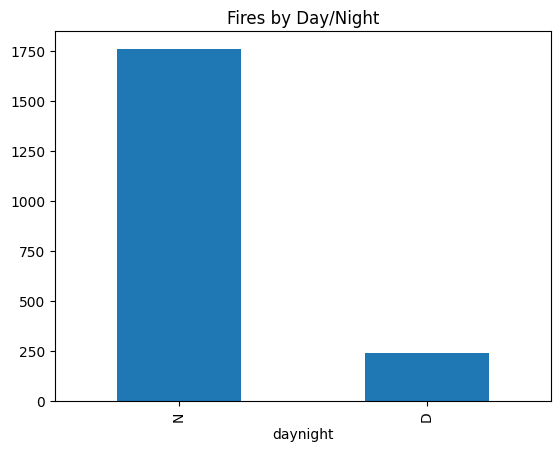

In [11]:
#Do more fires happen at night or during the day?
#Value_counts() count the occurrences of unique values in a Series or a DataFrame column.

df['daynight'].value_counts().plot(kind='bar', title='Fires by Day/Night')

In [12]:
#Any model that predicts “high confidence” will need class-imbalance handling (upsampling, class weights, etc)
#I'm thinking if I use daynight as a feature, the model might overfit on “night = fire”

#Goal: Predict high-confidence vs. not

#Encode
df['daynight_flag'] = (df['daynight'] == 'D').astype(int)  # 1 = Day, 0 = Night
df['conf_high']     = (df['confidence'] == 'h').astype(int)  # target for Option A

# Time features (hour of day)
df['hour'] = (df['acq_time'] // 100).astype(int)


X = df[['latitude','longitude','bright_ti4','bright_ti5','frp',
        'scan','track','hour','daynight_flag']]
y = df['conf_high']

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)

from sklearn.utils import class_weight
weights = class_weight.compute_sample_weight('balanced', y_train)

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, class_weight='balanced')
clf.fit(X_train, y_train, sample_weight=weights)

from sklearn.metrics import roc_auc_score
proba = clf.predict_proba(X_test)[:,1]
print("AUC-ROC:", roc_auc_score(y_test, proba))


AUC-ROC: 1.0


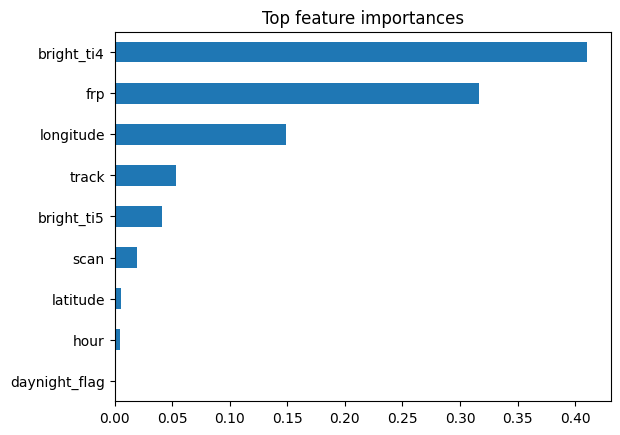

In [14]:
import pandas as pd
imp = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
imp.head(10).plot(kind='barh', title='Top feature importances'); plt.gca().invert_yaxis()

0
conf_high
0    0.986486
1    0.013514
Name: proportion, dtype: float64


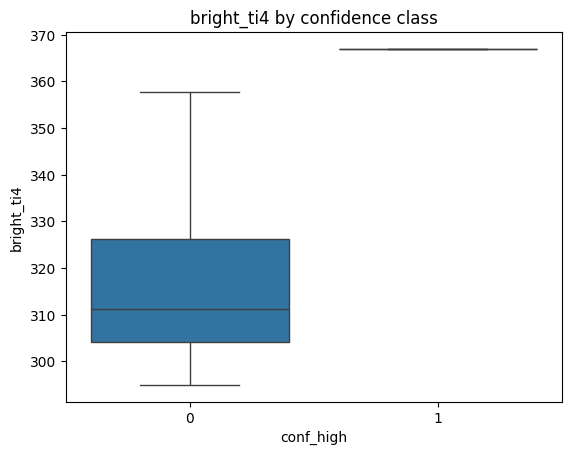

In [15]:
# Are there duplicate rows?
print(df.duplicated().sum())

# Class distribution
print(y.value_counts(normalize=True))

# Visual sanity-check: pick top feature vs. target
import seaborn as sns, matplotlib.pyplot as plt
sns.boxplot(x=y, y=df['bright_ti4'])
plt.title("bright_ti4 by confidence class"); plt.show()


In [16]:
import sys, pathlib
sys.path.append(str(pathlib.Path("..").resolve()))  # add project root to Python path
from src.wildfire_guard.firms_api import fetch_last_days

dest = fetch_last_days(7)      # update firms_api, rerun
df   = pd.read_csv(dest)

→ https://firms.modaps.eosdis.nasa.gov/api/country/csv/b1ed8010b715221edb34215a44f0ce14/VIIRS_SNPP_NRT/USA/7
  status: 200
✔ saved


In [17]:
df['conf_high']     = (df['confidence'] == 'h').astype(int)
df['daynight_flag'] = (df['daynight'] == 'D').astype(int)
df['hour']          = (df['acq_time'] // 100).astype(int)

X = df[['latitude', 'longitude', 'bright_ti4', 'bright_ti5',
        'frp', 'scan', 'track', 'hour', 'daynight_flag']]
y = df['conf_high']

print("High-confidence rows:", y.sum(), "of", len(y))

High-confidence rows: 264 of 5348


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

clf = RandomForestClassifier(
        n_estimators=400,
        class_weight="balanced",
        random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X, y, cv=cv, scoring="roc_auc")
print("CV AUCs:", scores, "mean:", scores.mean())


CV AUCs: [0.99909093 0.99952691 0.99936921 0.99966909 0.99994429] mean: 0.999520085003182


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

logreg = LogisticRegression(max_iter=1000, class_weight="balanced")
logreg.fit(X_train, y_train)
proba = logreg.predict_proba(X_test)[:, 1]
print("AUC (logistic):", roc_auc_score(y_test, proba))


AUC (logistic): 0.9989867200724794


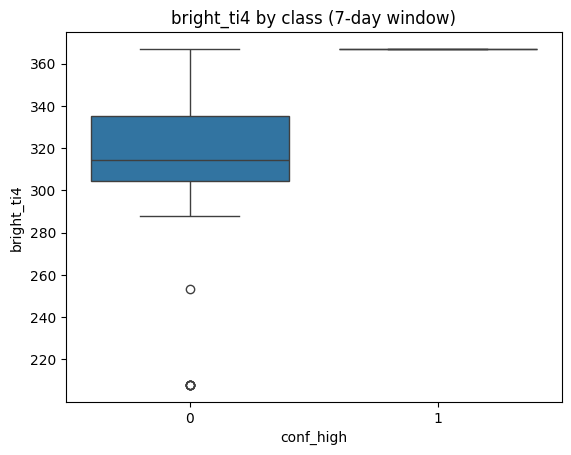

In [21]:
# Are any features totally disjoint?
import seaborn as sns, matplotlib.pyplot as plt
sns.boxplot(x=y, y=df['bright_ti4'])
plt.title("bright_ti4 by class (7-day window)")
plt.show()


In [24]:
import numpy as np

df['hour']          = (df['acq_time'] // 100).astype(int) # 0-23
df['daynight_flag'] = (df['daynight'] == 'D').astype(int) # 1 = Day, 0 = Night

# Log-transform FRP for regression target
df['log_frp'] = np.log1p(df['frp'])
features = ['bright_ti4', 'bright_ti5', 'scan', 'track',
            'hour', 'latitude', 'longitude', 'daynight_flag']
X = df[features]
y = df['log_frp']

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=400, random_state=42)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
mse  = mean_squared_error(y_test, pred)   # plain MSE
rmse = mse ** 0.5                         
print("RMSE (log-FRP):", rmse)
pred_frp  = np.expm1(pred)
true_frp  = np.expm1(y_test)

abs_pct_err = np.abs(pred_frp - true_frp) / true_frp * 100
print("Median % error:", np.median(abs_pct_err))


RMSE (log-FRP): 0.4167789492807969
Median % error: 30.309222403499437


In [29]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, KFold
lgb = LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=-1,
        num_leaves=64,
        random_state=42)

cv = KFold(5, shuffle=True, random_state=42)
rmse_scores = -cross_val_score(lgb, X, y, cv=cv,
                               scoring='neg_root_mean_squared_error')
print("LightGBM RMSE:", rmse_scores.mean())


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1131
[LightGBM] [Info] Number of data points in the train set: 4278, number of used features: 8
[LightGBM] [Info] Start training from score 1.479144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1131
[LightGBM] [Info] Number of data points in the train set: 4278, number of used features: 8
[LightGBM] [Info] Start training from score 1.486299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1131
[LightGBM] [Info] Number of data points in the train set: 4278, number of used features: 8
[LightGBM] [Info] Start training 

In [30]:
import joblib, pathlib
pathlib.Path("models").mkdir(exist_ok=True)
joblib.dump(rf, "models/rf_frp_model.pkl")
print("✓ saved models/rf_frp_model.pkl")


✓ saved models/rf_frp_model.pkl


✓ saved figures/viirs_map.png


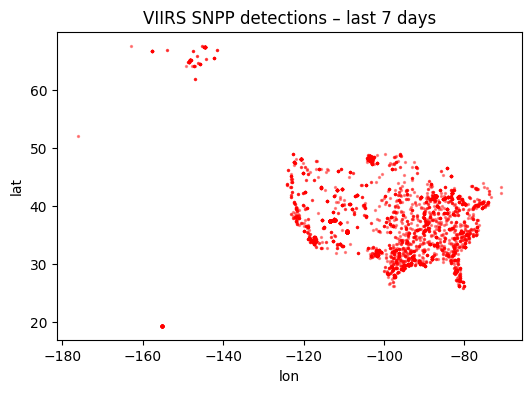

In [31]:
import matplotlib.pyplot as plt, pathlib
plt.figure(figsize=(6,4))
plt.scatter(df['longitude'], df['latitude'], s=2, c='red', alpha=0.4)
plt.title("VIIRS SNPP detections – last 7 days"); plt.xlabel("lon"); plt.ylabel("lat")
pathlib.Path("figures").mkdir(exist_ok=True)
plt.savefig("figures/viirs_map.png", dpi=300, bbox_inches="tight")
print("✓ saved figures/viirs_map.png")
plt.show()
